# Binarize Data

Change file name as desired

In [27]:
file_name = "Metazygia wittfeldae Monitor 1 activity_DD"

In [32]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from datetime import datetime
from datetime import timedelta
from sklearn import preprocessing

df = pd.read_csv(file_name + '.csv', index_col = 0)

# Binarizes data according to default threshold 0, values greater than 0 map to 1

from sklearn.preprocessing import Binarizer
bin = Binarizer()

# For each spider column, extract the values from dataframe and reshape into double array, 
# then binarize the values and transform it back into dataframe

def binarizeData(df):
    for x in df.loc[:, df.columns.str.startswith('s')]:
        col = df[x].values
        col = col.reshape(-1, 1)
        df[x] = bin.fit_transform(col)
        
    df.to_csv(file_name + "_binary.csv")
    display(df)
    
binarizeData(df)

,Date,Time,lights,s1,s2,s3,s4,s5,s6,s7,...,s23,s24,s25,s26,s27,s28,s29,s30,s31,s32
Date_Time,,,,,,,,,,,,,,,,,,,,,
2017-06-19 00:00:00,19-Jun-17,0:00:00,0,0,1,0,0,0,1,0,...,0,0,0,0,0,0,0,0,1,0
2017-06-19 00:01:00,19-Jun-17,0:01:00,0,0,1,0,0,0,1,0,...,0,0,0,0,0,0,0,0,1,0
2017-06-19 00:02:00,19-Jun-17,0:02:00,0,0,1,0,0,0,1,0,...,0,1,0,0,0,0,0,0,0,0
2017-06-19 00:03:00,19-Jun-17,0:03:00,0,0,1,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
2017-06-19 00:04:00,19-Jun-17,0:04:00,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,1,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2017-06-27 23:55:00,27-Jun-17,23:55:00,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,1,0
2017-06-27 23:56:00,27-Jun-17,23:56:00,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
2017-06-27 23:57:00,27-Jun-17,23:57:00,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,1


# Create Run Duration Dataframe

Change filename as desired

In [33]:
# Read Spider activity CSV file
filename = 'Metazygia wittfeldae Monitor 1 activity_DD_binary'
df = pd.read_csv(filename + '.csv', index_col = 0)
df['Date_Time'] = pd.to_datetime(df.Date + ' ' + df.Time)
df = df.set_index('Date_Time')

In [34]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
from datetime import timedelta
import seaborn as sns
import pylab as py

# This function takes parameters df_switch and col and finds the switch from running to not running. 
# df_switch is a copy of the given dataframe with reset indices. x represents the spider column.

def adjust_start_and_end(df_switch, col):
    # create switch column for column: switch from 0 to 1 labeled 1 in corresponding row
    # and switch from 1 to 0 labeled -1. No switch labeled 0 in corresponding row
    df_switch['switch'] = df_switch[col].diff()
    
    # checking for corner cases
    
    # if run begins immediately, corresponding row in switch column labeled 1
    if df_switch.at[0, col] == 1:
            df_switch.at[0, 'switch'] = 1
    
    # if spider run still occurs at the end, corresponding row in switch column labeled -1
    if df_switch.at[df_switch.index[-1], col] == 1 and df_switch.at[df_switch.index[-2], col] == 1:
            df_switch.at[df_switch.index[-1], 'switch'] = -1
            
    # if spider not running at the end, corresponding row in switch column labeled 0
    if df_switch.at[df_switch.index[-1], col] == 1 and df_switch.at[df_switch.index[-2], col] == 0:
            df_switch.at[df_switch.index[-1], 'switch'] = 0
            
    return

# This function takes parameters df_switch and col and finds the run duration of the spider; df_switch 
# is a copy of the given dataframe with reset indices. x represents the spider column.

def find_duration(df_switch, col):
    # create list of all start run indices
    runStart = df_switch.index[df_switch['switch'] == 1].tolist()
    
    # create list of all end run indices
    runEnd = df_switch.index[df_switch['switch'] == -1].tolist()
    
    # create list of run duration by subtracting run end indices and run start indices
    runDuration = np.subtract(runEnd, runStart)
    
    return runDuration

# This function displays the new dataframe and saves it to a csv file.

def create_spider_run_duration_dataframe(df):
    # create new dataframe
    newdf = pd.DataFrame()
    df_switch = df.reset_index().copy()
    
    # loop through all spider columns and call functions
    for col in df.loc[:, df.columns.str.startswith('s')]:
        adjust_start_and_end(df_switch, col)
        runDuration = find_duration(df_switch, col)
        
        # create series from run duration list
        s = pd.Series(runDuration)
        
        # appends columns and fills columns outside the intersection with NaN values
        newdf = pd.concat([newdf, s.rename(col)], axis = 1) 
        
        # converts all cells to float as NaN values cannot be converted to integers
        newdf[col] = newdf[col].astype(float)
    
    display(newdf)
    run_duration_df = newdf.to_csv(filename + "_run_duration.csv")

In [35]:
create_spider_run_duration_dataframe(df)

,s1,s2,s3,s4,s5,s6,s7,s8,s9,s10,...,s23,s24,s25,s26,s27,s28,s29,s30,s31,s32
0,4.0,4.0,5.0,8.0,3.0,3.0,32.0,1.0,1.0,14.0,...,15.0,5.0,2.0,NaN,4.0,NaN,2.0,1.0,2.0,1.0
1,1.0,10.0,2.0,2.0,1.0,8.0,27.0,1.0,3.0,3.0,...,4.0,5.0,1.0,NaN,2.0,NaN,2.0,3.0,1.0,1.0
2,2.0,2.0,1.0,2.0,3.0,1.0,2.0,2.0,1.0,1.0,...,31.0,1.0,1.0,NaN,8.0,NaN,4.0,2.0,2.0,3.0
3,2.0,12.0,10.0,2.0,2.0,6.0,8.0,1.0,1.0,5.0,...,1.0,2.0,1.0,NaN,19.0,NaN,4.0,1.0,2.0,2.0
4,1.0,4.0,6.0,4.0,1.0,5.0,1.0,2.0,1.0,1.0,...,10.0,2.0,3.0,NaN,2.0,NaN,6.0,1.0,1.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1226,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1227,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1228,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1229,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


# Creating Histograms for Raw and Resampled Data

In [ ]:
# Read Spider activity CSV file
filename = 'Metazygia wittfeldae Monitor 1 activity_DD_binary_run_duration'
filename2 = "Metazygia wittfeldae Monitor 1 activity_DD_reindex_binary_run_duration"
df = pd.read_csv(filename + '.csv', index_col = 0)
df2 = pd.read_csv(filename2 + '.csv', index_col = 0)

Our data was collected in 1 minute intervals; therefore, we resampled our data by getting the sum of every two minute interval. This interval can be changed in the resampling code to user's preference.

In [7]:
def set_histogram(col, plt, axes, ylim):
    # create two histograms side by side: binarized run duration histogram on the left (axis 0) and 
    # resampled binarized run duration histogram on the right (axis 1)
    axes[0].set_title(col)
    axes[1].set_title(col + ' Resampled Every 2 Minutes')
    axes[0].set_xlabel('Run Duration')
    axes[1].set_xlabel('Run Duration')
    axes[0].set_ylim(0, ylim)
    axes[1].set_ylim(0, ylim)
    # adjust padding around the histograms
    plt.tight_layout()
    
    return

def show_all_histograms(df):
    # set bins and y-axis limit
    bin_size = np.arange(0, 30, 2, dtype= int)
    ylim = 0.5
    
    # loop through dataframe columns to plot each column
    for i, col in enumerate(df.columns):
        fig, axes = plt.subplots(1, 2)
        fig.suptitle('DD Run Duration Distribution')
        set_histogram(col, plt, axes, ylim)
        
        # create histogram with data from dataframe
        sns.histplot(data = df, x = col, ax = axes[0], stat = 'density', bins = bin_size)
        sns.histplot(data = df2, x = col, ax = axes[1], stat = 'density', bins = bin_size)

        plt.savefig(col + "_DD.jpeg")

    return

/var/folders/jt/ss6zd2nx0bv4h_3q_d2qtldm0000gn/T/ipykernel_51261/4249017519.py:28: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, axes = plt.subplots(1, 2)


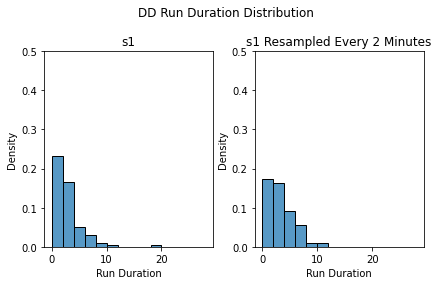

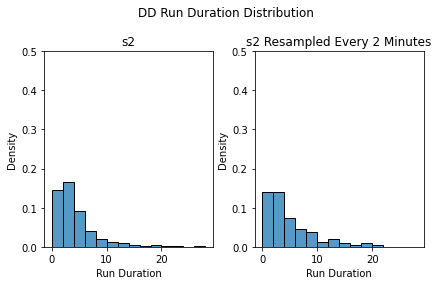

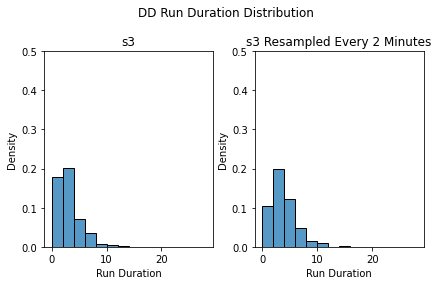

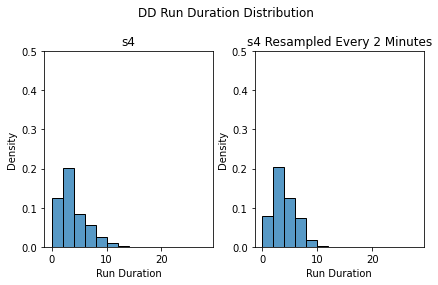

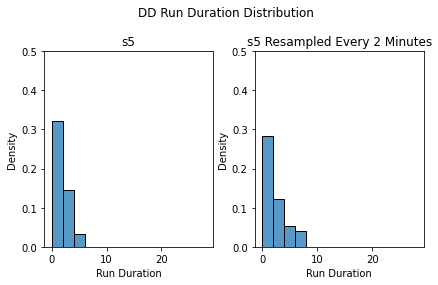

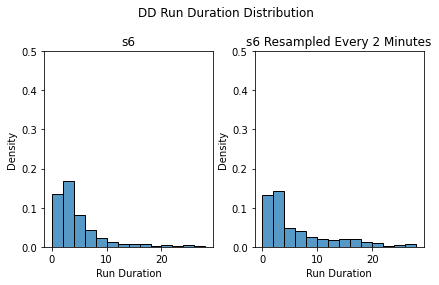

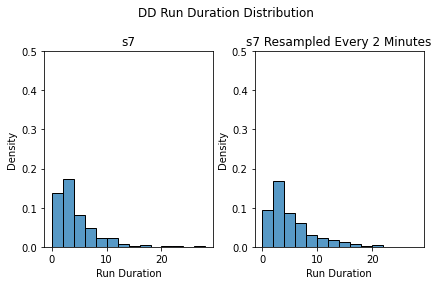

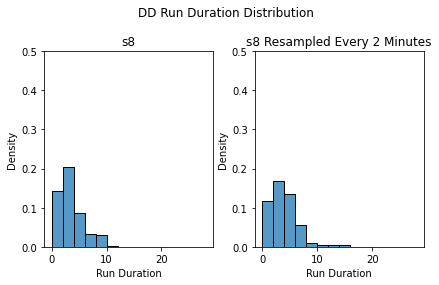

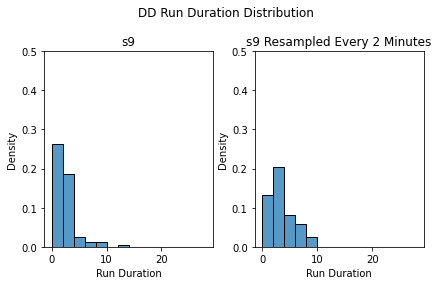

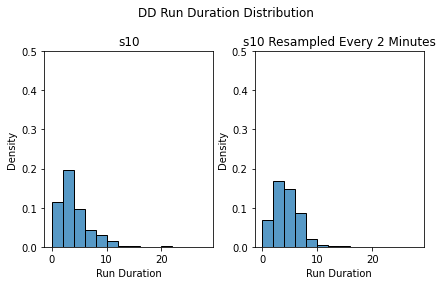

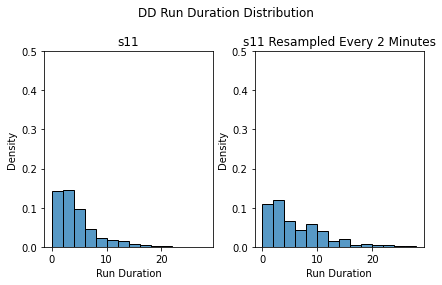

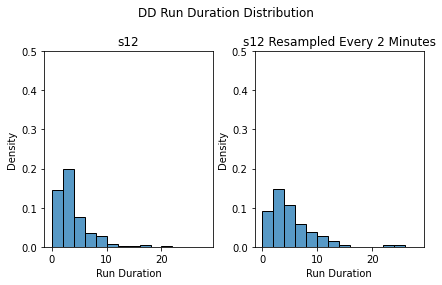

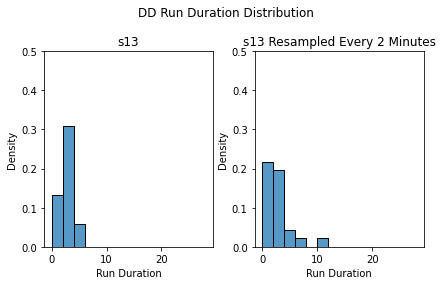

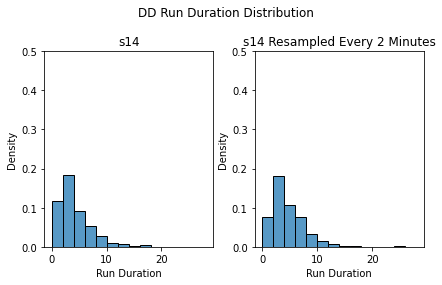

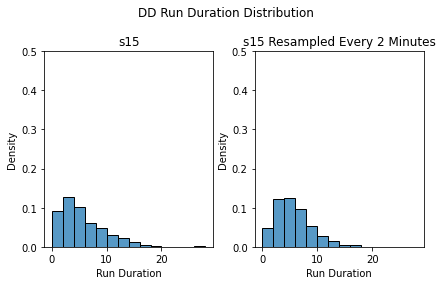

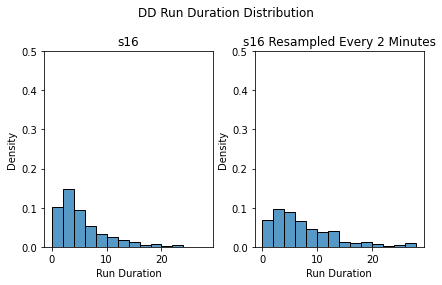

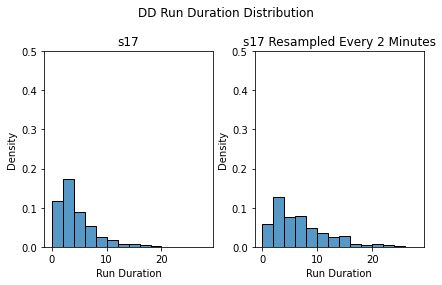

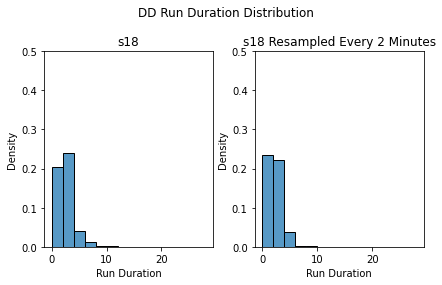

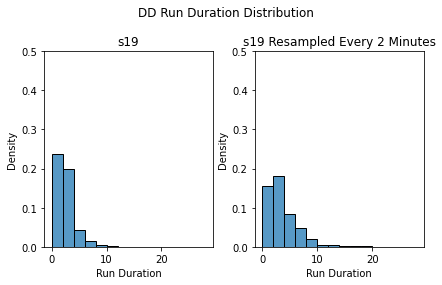

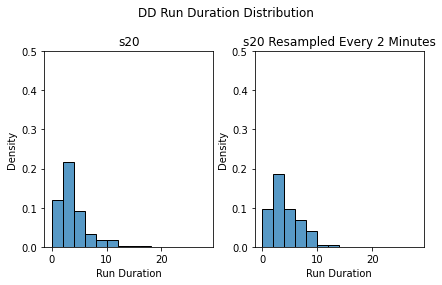

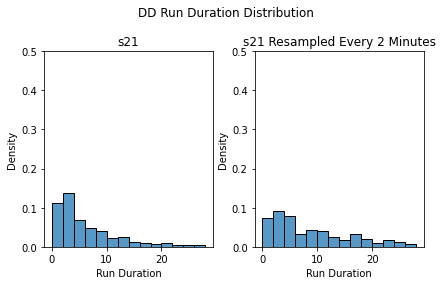

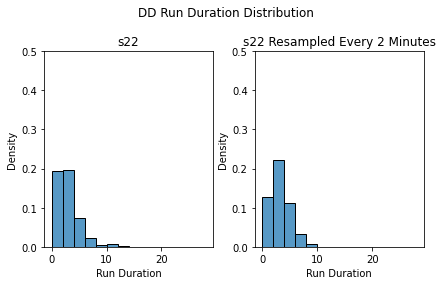

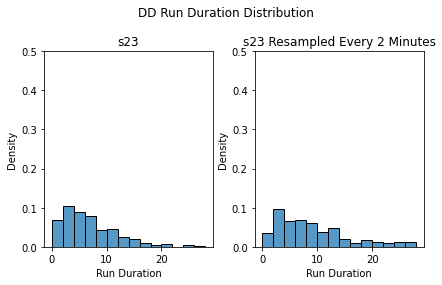

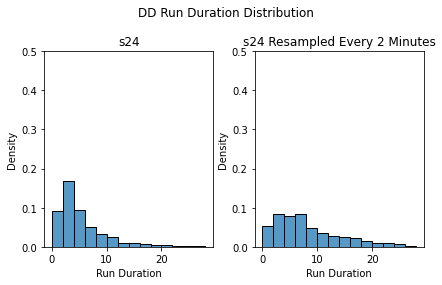

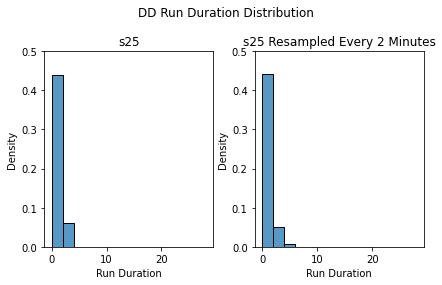

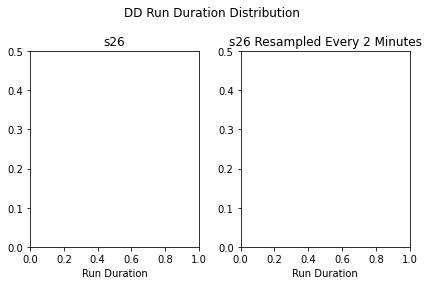

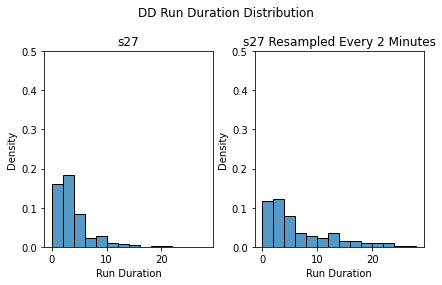

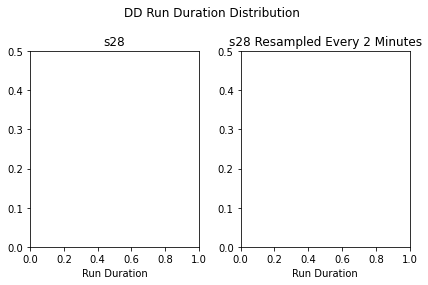

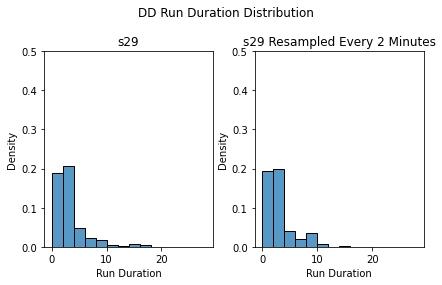

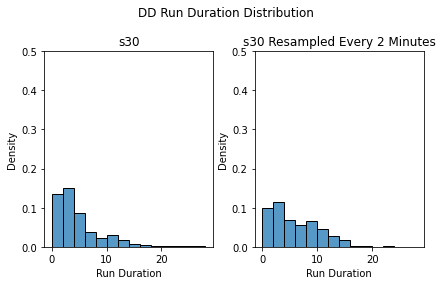

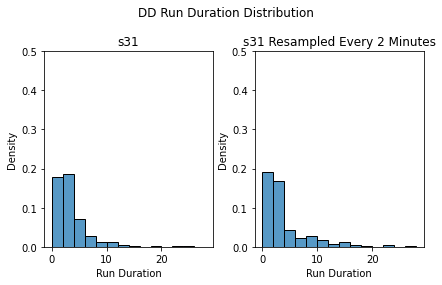

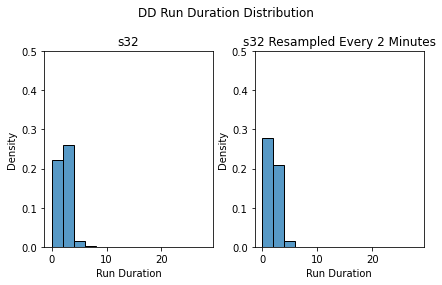

In [8]:
show_all_histograms(df)

# Creating Histogram from Raw Data

If desired, the user can also just visualize the run duration of non-resampled data below.

In [9]:
def set_histogram(col, plt, ylim):
    # create binarized run duration histogram frame
    plt.title(col + ' DD Run Duration')
    plt.xlabel('Run Duration')
    plt.ylim(0, ylim)
    # adjust padding around the histograms
    plt.tight_layout()
    
    return

def show_all_histograms(df):
    # set bins and y-axis limit
    bin_size = np.arange(0, 30, 2, dtype= int)
    ylim = 0.5
    
    # loop through dataframe columns to plot each column
    for i, col in enumerate(df.columns):
        plt.figure(i)
        set_histogram(col, plt, ylim)

        # create histogram with data from dataframe
        sns.histplot(data = df, x = col, stat = 'density', bins = bin_size)

        plt.savefig(col + "_DD.jpeg")

    return

/var/folders/jt/ss6zd2nx0bv4h_3q_d2qtldm0000gn/T/ipykernel_51261/796410568.py:18: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure(i)


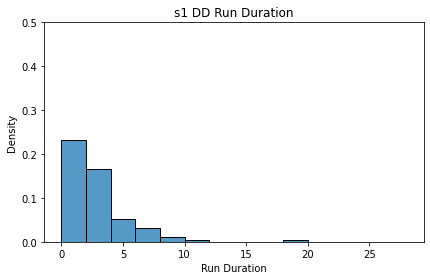

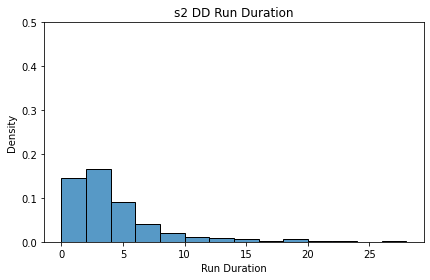

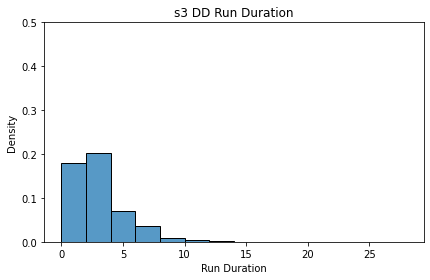

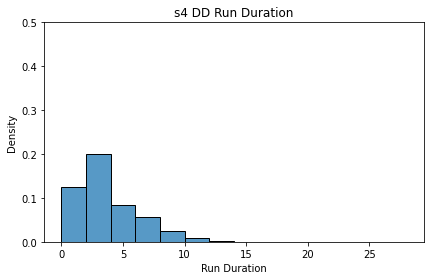

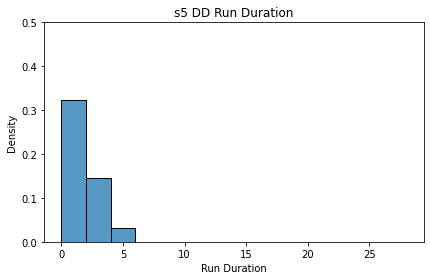

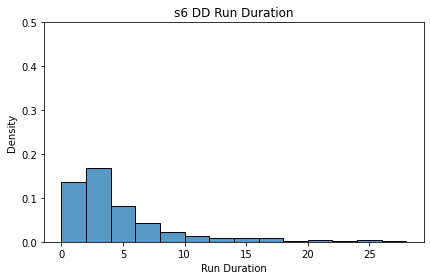

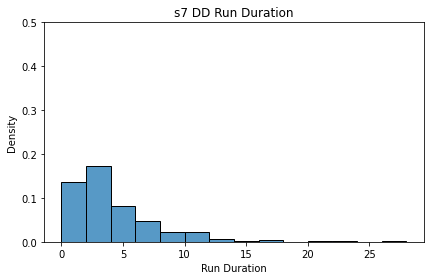

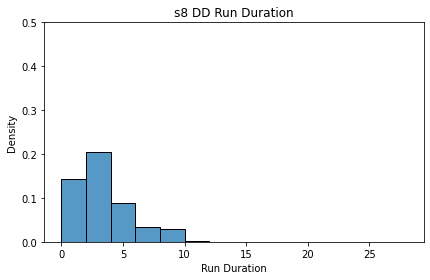

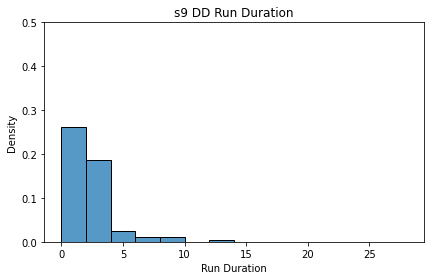

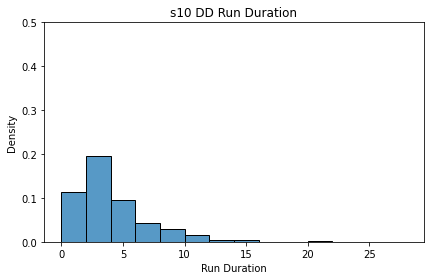

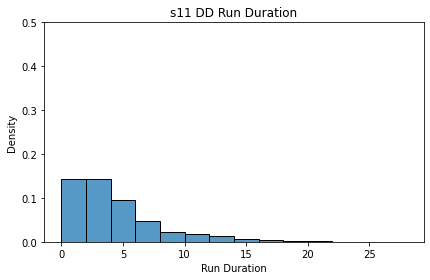

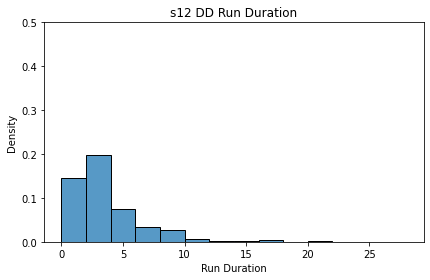

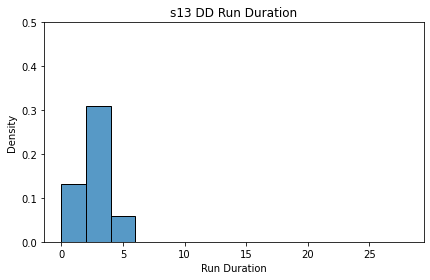

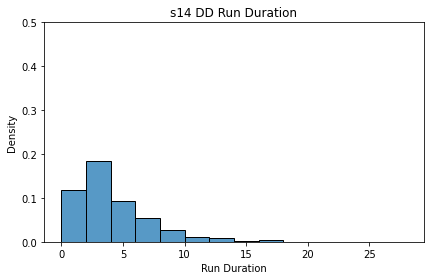

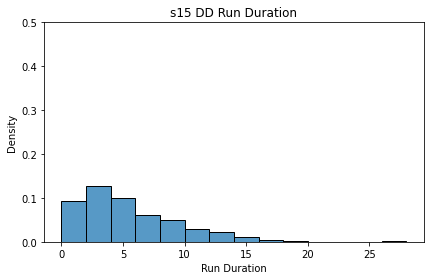

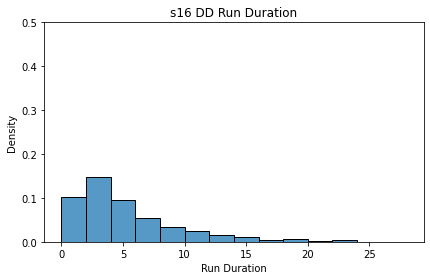

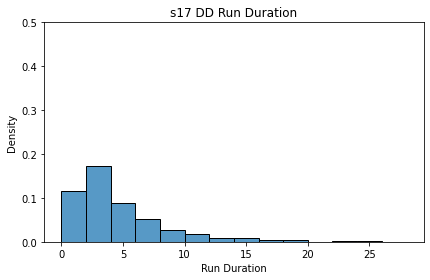

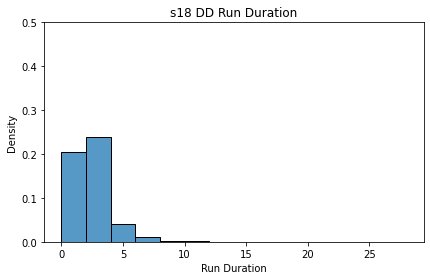

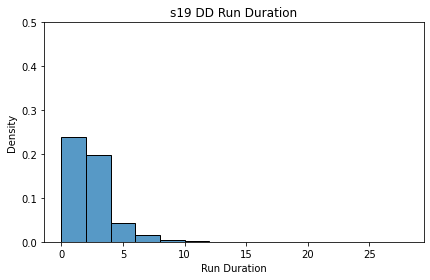

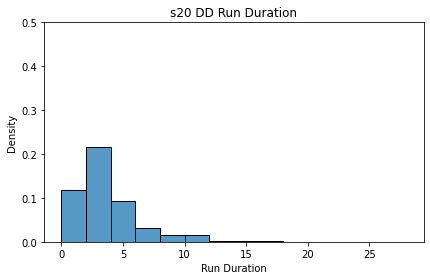

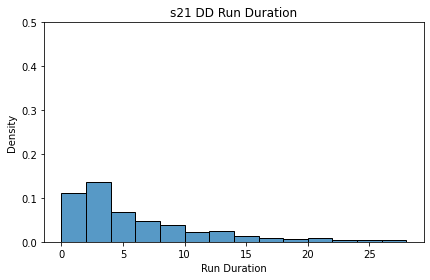

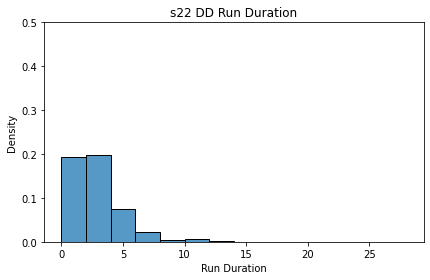

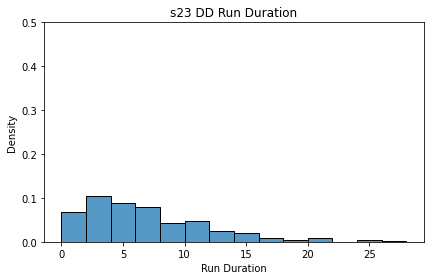

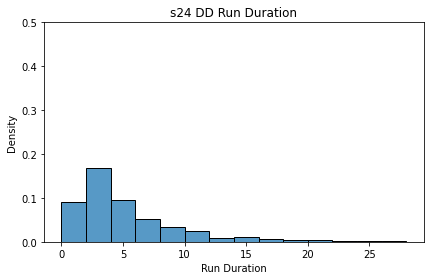

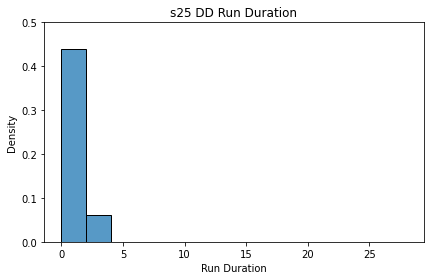

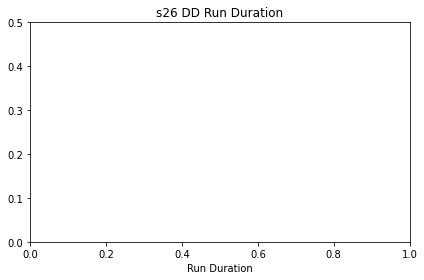

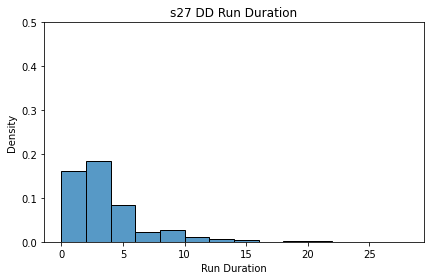

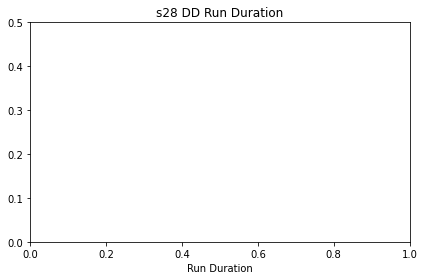

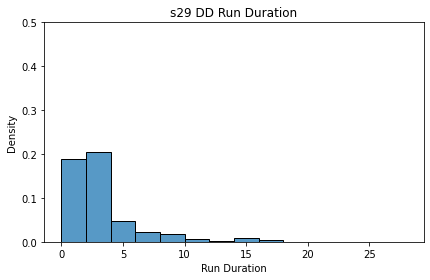

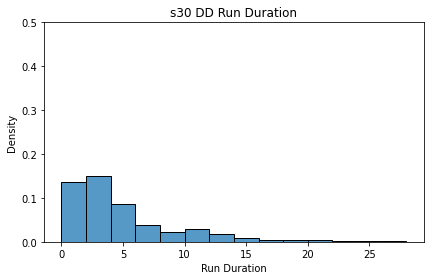

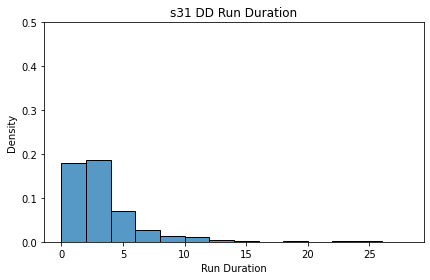

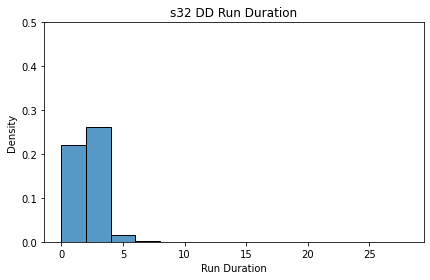

In [10]:
show_all_histograms(df)